In [1]:
import pandas as pd
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

2025-10-02 01:24:13.488114: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def build_mlp(column_count):
    inputs = keras.Input(shape=(column_count,))
    
    x = keras.layers.Dense(256)(inputs)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Dropout(0.6)(x)
    
    x = keras.layers.Dense(128)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Dropout(0.5)(x)

    x = keras.layers.Dense(16)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Dropout(0.2)(x)
    
    output = keras.layers.Dense(1, activation='sigmoid')(x)
    return keras.Model(inputs, output)

In [3]:
from sklearn.discriminant_analysis import StandardScaler


df = pd.read_csv('cumulative_2025.10.01_20.20.34.csv', comment='#')
cols_to_drop = [
    'rowid', 'kepid', 'kepoi_name', 'kepler_name', 'koi_vet_stat', 'koi_vet_date',
    'koi_pdisposition', 'koi_score', 'koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co', 
    'koi_fpflag_ec', 'koi_disp_prov', 'koi_comment', 'koi_eccen', 'koi_eccen_err1', 
    'koi_eccen_err2', 'koi_longp', 'koi_longp_err1', 'koi_longp_err2', 'koi_ingress', 
    'koi_ingress_err1', 'koi_ingress_err2',  'koi_sma_err1', 'koi_sma_err2', 'koi_incl_err1', 
    'koi_incl_err2', 'koi_teq_err1', 'koi_teq_err2', 'koi_limbdark_mod', 'koi_ldm_coeff4', 
    'koi_ldm_coeff3', 'koi_tce_plnt_num', 'koi_tce_delivname', 'koi_quarters', 
    'koi_bin_oedp_sig', 'koi_trans_mod', 'koi_model_dof', 'koi_model_chisq', 
    'koi_datalink_dvr', 'koi_datalink_dvs', 'koi_sage', 'koi_sage_err1', 'koi_sage_err2'
]

df = df.drop(columns=cols_to_drop)
df = df[df['koi_disposition'] != 'CANDIDATE']
df = df.reset_index(drop=True)

Y = df['koi_disposition'].map({'FALSE POSITIVE': 0, 'CONFIRMED': 1}).astype(np.float32)
X = df.drop(columns=['koi_disposition'])

X_filled = X.fillna(0)
X_encoded = pd.get_dummies(X_filled, drop_first=False).astype(np.float32).values

scaler = StandardScaler()
X_encoded = scaler.fit_transform(X_encoded).astype(np.float32)



In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X_encoded, Y, test_size=0.2, random_state=42, shuffle=True
)

In [5]:
model = build_mlp(X_encoded.shape[1])
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy'
)
model.summary()

I0000 00:00:1759386257.369205  399326 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6631 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 105)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        27,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,713 (248.88 KB)

 Trainable params: 62,913 (245.75 KB)

 Non-trainable params: 800 (3.12 KB)

In [6]:
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=50,
    restore_best_weights=True
)

In [7]:
model.fit(
    X_train, Y_train,
    batch_size=64,
    epochs=1000,
    validation_split=0.1,
    callbacks=[early_stop]
)

Epoch 1/1000


2025-10-02 01:24:20.770626: I external/local_xla/xla/service/service.cc:163] XLA service 0x7422b4007240 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-02 01:24:20.770641: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 2070, Compute Capability 7.5
2025-10-02 01:24:20.835429: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-02 01:24:21.305568: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91301


62/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8498

I0000 00:00:1759386263.751185  399434 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


86/86 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - loss: 0.7950 - val_loss: 0.5890
Epoch 2/1000
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6550 - val_loss: 0.5093
Epoch 3/1000
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5686 - val_loss: 0.4762
Epoch 4/1000
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5066 - val_loss: 0.4472
Epoch 5/1000
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4533 - val_loss: 0.4198
Epoch 6/1000
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4282 - val_loss: 0.3915
Epoch 7/1000
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3981 - val_loss: 0.3720
Epoch 8/1000
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3685 - val_loss: 0.3516
Epoch 9/1000
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3440 - val_loss: 0.3321
Epoch 10/1000
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3245 - val_loss: 0.3161
Epoch 11/1000
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3111 - val_loss: 0.3034
Epoch 12/1000
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2

In [8]:
model.save('xd.keras')

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step 
                precision    recall  f1-score   support

FALSE POSITIVE       0.93      0.96      0.95       557
     CONFIRMED       0.98      0.96      0.97       960

      accuracy                           0.96      1517
     macro avg       0.95      0.96      0.96      1517
  weighted avg       0.96      0.96      0.96      1517



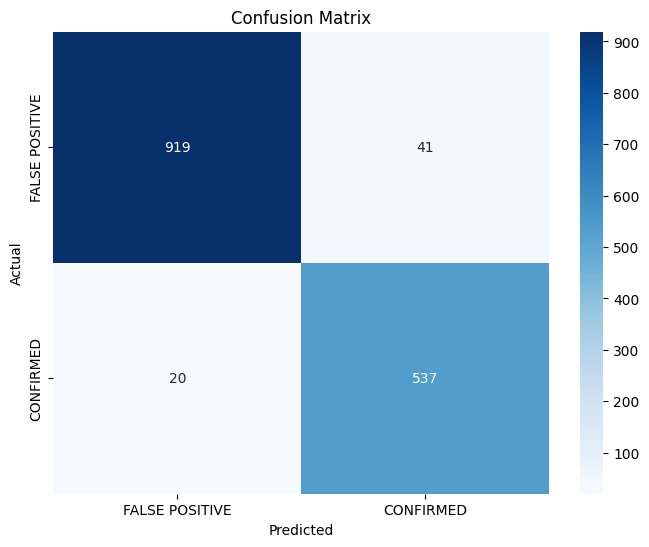

In [9]:
labels = ['FALSE POSITIVE', 'CONFIRMED']

Y_pred_probs = model.predict(X_test)
Y_pred = (Y_pred_probs >= 0.5).astype(int).flatten()
Y_true = Y_test.values.astype(int).flatten() 

Y_pred_strings = [labels[i] for i in Y_pred]
Y_true_strings = [labels[i] for i in Y_true]

cm = confusion_matrix(Y_true_strings, Y_pred_strings, labels=labels)
print(classification_report(Y_true_strings, Y_pred_strings, target_names=labels))
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()